# What is a Deep Gaussian Process?

## Neil D. Lawrence 3rd December 2017

In [1]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import daft
import GPy
import pods

import teaching_plots as plot

rc("font", **{'family':'sans-serif','sans-serif':['Helvetica'],'size':10})
rc("text", usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

$\newcommand{\Amatrix}{\mathbf{A}}
\newcommand{\KL}[2]{\text{KL}\left( #1\,\|\,#2 \right)} % Kullback Leibler divergence
\newcommand{\Kaast}{\kernelMatrix_{\mathbf{ \ast}\mathbf{ \ast}}}
\newcommand{\Kastu}{\kernelMatrix_{\mathbf{\ast} \inducingVector}}
\newcommand{\Kff}{\kernelMatrix_{\mappingFunctionVector \mappingFunctionVector}}
\newcommand{\Kfu}{\kernelMatrix_{\mappingFunctionVector \inducingVector}}
\newcommand{\Kuast}{\kernelMatrix_{\inducingVector \bf\ast}}
\newcommand{\Kuf}{\kernelMatrix_{\inducingVector \mappingFunctionVector}}
\newcommand{\Kuu}{\kernelMatrix_{\inducingVector \inducingVector}}
\newcommand{\Kuui}{\Kuu^{-1}}
\newcommand{\Qaast}{{\bf Q}_{\bf \ast \ast}}
\newcommand{\Qastf}{{\bf Q}_{\ast \mappingFunction}}
\newcommand{\Qfast}{{\bf Q}_{\mappingFunctionVector \bf \ast}}
\newcommand{\Qff}{{\bf Q}_{\mappingFunctionVector \mappingFunctionVector}}
\newcommand{\activationFunction}{\phi}
\newcommand{\activationMatrix}{\boldsymbol{\Phi}}
\newcommand{\activationScalar}{\activationFunction}
\newcommand{\activationVector}{\boldsymbol{\activationFunction}}
\newcommand{\aMatrix}{\mathbf{A}}
\newcommand{\aScalar}{a}
\newcommand{\aVector}{\mathbf{a}}
\newcommand{\acceleration}{a}
\newcommand{\bMatrix}{\mathbf{B}}
\newcommand{\bScalar}{b}
\newcommand{\bVector}{\mathbf{b}}
\newcommand{\basisFunc}{\phi}
\newcommand{\basisFuncVector}{\boldsymbol{\basisFunc}}
\newcommand{\basisFunction}{\phi}
\newcommand{\basisLocation}{\mu}
\newcommand{\basisMatrix}{\boldsymbol{\Phi}}
\newcommand{\basisScalar}{\basisFunction}
\newcommand{\basisVector}{\boldsymbol{\basisFunction}}
\newcommand{\bigO}{\mathcal{O}}
\newcommand{\binomProb}{\pi}
\newcommand{\cMatrix}{\mathbf{C}}
\newcommand{\cbasisMatrix}{\hat{\boldsymbol{\Phi}}}
\newcommand{\cdataMatrix}{\hat{\dataMatrix}}
\newcommand{\cdataScalar}{\hat{\dataScalar}}
\newcommand{\cdataVector}{\hat{\dataVector}}
\newcommand{\centeredKernelMatrix}{\mathbf{\MakeUppercase{\centeredKernelScalar}}}
\newcommand{\centeredKernelScalar}{b}
\newcommand{\centeredKernelVector}{\centeredKernelScalar}
\newcommand{\centeringMatrix}{\mathbf{H}}
\newcommand{\chiSquaredDist}[2]{\chi_{#1}^{2}\left(#2\right)}
\newcommand{\chiSquaredSamp}[1]{\chi_{#1}^{2}}
\newcommand{\conditionalCovariance}{\boldsymbol{\Sigma}}
\newcommand{\coregionalizationMatrix}{\mathbf{\MakeUppercase{\coregionalizationScalar}}}
\newcommand{\coregionalizationScalar}{b}
\newcommand{\coregionalizationVector}{\mathbf{\coregionalizationScalar}}
\newcommand{\covDist}[2]{\text{cov}_{#2}\left(#1\right)}
\newcommand{\covSamp}[1]{\text{cov}\left(#1\right)}
\newcommand{\covarianceScalar}{c}
\newcommand{\covarianceVector}{\mathbf{\covarianceScalar}}
\newcommand{\covarianceMatrix}{\mathbf{C}}
\newcommand{\covarianceTwoScalar}{s}
\newcommand{\covarianceTwoVector}{\mathbf{\covarianceTwoScalar}}
\newcommand{\covarianceTwoMatrix}{\mathbf{S}}
\newcommand{\croupierScalar}{s}
\newcommand{\croupierVector}{\mathbf{\croupierScalar}}
\newcommand{\croupierMatrix}{\mathbf{\MakeUppercase{\croupierScalar}}}
\newcommand{\dataDim}{p}
\newcommand{\dataIndex}{i}
\newcommand{\dataIndexTwo}{j}
\newcommand{\dataMatrix}{\mathbf{Y}}
\newcommand{\dataScalar}{y}
\newcommand{\dataSet}{\mathcal{D}}
\newcommand{\dataStd}{\sigma}
\newcommand{\dataVector}{\mathbf{\dataScalar}}
\newcommand{\decayRate}{d}
\newcommand{\degreeMatrix}{\mathbf{\MakeUppercase{\degreeScalar}}}
\newcommand{\degreeScalar}{d}
\newcommand{\degreeVector}{\mathbf{\degreeScalar}}
\newcommand{\det}[1]{\left|#1\right|}
\newcommand{\diag}[1]{\text{diag}\left(#1\right)}
\newcommand{\diagonalMatrix}{\mathbf{D}}
\newcommand{\diff}[2]{\frac{\text{d}#1}{\text{d}#2}}
\newcommand{\diffTwo}[2]{\frac{\text{d}^2#1}{\text{d}#2^2}}
\newcommand{\displacement}{x}
\newcommand{\displacementVector}{\textbf{\displacement}}
\newcommand{\distanceMatrix}{\mathbf{\MakeUppercase{\distanceScalar}}}
\newcommand{\distanceScalar}{d}
\newcommand{\distanceVector}{\mathbf{\distanceScalar}}
\newcommand{\eigenvaltwo}{\ell}
\newcommand{\eigenvaltwoMatrix}{\mathbf{L}}
\newcommand{\eigenvaltwoVector}{\mathbf{l}}
\newcommand{\eigenvalue}{\lambda}
\newcommand{\eigenvalueMatrix}{\boldsymbol{\Lambda}}
\newcommand{\eigenvalueVector}{\boldsymbol{\lambda}}
\newcommand{\eigenvector}{\mathbf{\eigenvectorScalar}}
\newcommand{\eigenvectorMatrix}{\mathbf{U}}
\newcommand{\eigenvectorScalar}{u}
\newcommand{\eigenvectwo}{\mathbf{v}}
\newcommand{\eigenvectwoMatrix}{\mathbf{V}}
\newcommand{\eigenvectwoScalar}{v}
\newcommand{\entropy}[1]{\mathcal{H}\left(#1\right)}
\newcommand{\errorFunction}{E}
\newcommand{\expDist}[2]{\left<#1\right>_{#2}}
\newcommand{\expSamp}[1]{\left<#1\right>}
\newcommand{\expectation}[1]{\left\langle #1 \right\rangle }
\newcommand{\expectationDist}[2]{\left\langle #1 \right\rangle _{#2}}
\newcommand{\expectedDistanceMatrix}{\mathcal{D}}
\newcommand{\eye}{\mathbf{I}}
\newcommand{\fantasyDim}{r}
\newcommand{\fantasyMatrix}{\mathbf{\MakeUppercase{\fantasyScalar}}}
\newcommand{\fantasyScalar}{z}
\newcommand{\fantasyVector}{\mathbf{\fantasyScalar}}
\newcommand{\featureStd}{\varsigma}
\newcommand{\gammaCdf}[3]{\mathcal{GAMMA CDF}\left(#1|#2,#3\right)}
\newcommand{\gammaDist}[3]{\mathcal{G}\left(#1|#2,#3\right)}
\newcommand{\gammaSamp}[2]{\mathcal{G}\left(#1,#2\right)}
\newcommand{\gaussianDist}[3]{\mathcal{N}\left(#1|#2,#3\right)}
\newcommand{\gaussianSamp}[2]{\mathcal{N}\left(#1,#2\right)}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\heaviside}{H}
\newcommand{\hiddenMatrix}{\mathbf{\MakeUppercase{\hiddenScalar}}}
\newcommand{\hiddenScalar}{h}
\newcommand{\hiddenVector}{\mathbf{\hiddenScalar}}
\newcommand{\identityMatrix}{\eye}
\newcommand{\inducingInputScalar}{z}
\newcommand{\inducingInputVector}{\mathbf{\inducingInputScalar}}
\newcommand{\inducingInputMatrix}{\mathbf{\MakeUppercase{\inducingInputScalar}}}
\newcommand{\inducingScalar}{u}
\newcommand{\inducingVector}{\mathbf{\inducingScalar}}
\newcommand{\inducingMatrix}{\mathbf{\MakeUppercase{\inducingScalar}}}
\newcommand{\inlineDiff}[2]{\text{d}#1/\text{d}#2}
\newcommand{\inputDim}{q}
\newcommand{\inputMatrix}{{\bf X}}
\newcommand{\inputScalar}{x}
\newcommand{\inputSpace}{\mathcal{X}}
\newcommand{\inputVector}{{\bf \inputScalar}}
\newcommand{\iterNum}{k}
\newcommand{\kernel}{\kernelScalar}
\newcommand{\kernelMatrix}{\mathbf{K}} % Kernel matrix
\newcommand{\kernelScalar}{k}
\newcommand{\kernelVector}{\mathbf{\kernelScalar}}
\newcommand{\kff}{\kernelScalar_{\mappingFunction \mappingFunction}}
\newcommand{\kfu}{\kernelVector_{\mappingFunction \inducingScalar}}
\newcommand{\kuf}{\kernelVector_{\inducingScalar \mappingFunction}}
\newcommand{\kuu}{\kernelVector_{\inducingScalar \inducingScalar}}
\newcommand{\lagrangeMultiplier}{\lambda}
\newcommand{\lagrangeMultiplierMatrix}{\boldsymbol{\Lambda}}
\newcommand{\lagrangian}{L}
\newcommand{\laplacianFactor}{\mathbf{\MakeUppercase{\laplacianFactorScalar}}}
\newcommand{\laplacianFactorScalar}{m}
\newcommand{\laplacianFactorVector}{\mathbf{\laplacianFactorScalar}}
\newcommand{\laplacianMatrix}{\mathbf{L}}
\newcommand{\laplacianScalar}{\ell}
\newcommand{\laplacianVector}{\mathbf{\ell}}
\newcommand{\latentDim}{q}
\newcommand{\latentDistanceMatrix}{\boldsymbol{\Delta}}
\newcommand{\latentDistanceScalar}{\delta}
\newcommand{\latentDistanceVector}{\boldsymbol{\delta}}
\newcommand{\latentForce}{f}
\newcommand{\latentFunction}{u}
\newcommand{\latentFunctionVector}{\mathbf{\latentFunction}}
\newcommand{\latentFunctionMatrix}{\mathbf{\MakeUppercase{\latentFunction}}}
\newcommand{\latentIndex}{j}
\newcommand{\latentScalar}{x}
\newcommand{\latentVector}{\mathbf{\latentScalar}}
\newcommand{\latentMatrix}{\mathbf{\MakeUppercase{\latentScalar}}}
\newcommand{\learnRate}{\eta}
\newcommand{\lengthScale}{\ell}
\newcommand{\rbfWidth}{\ell}
\newcommand{\likelihoodBound}{\mathcal{L}}
\newcommand{\likelihoodFunction}{L}
\newcommand{\locationScalar}{\mu}
\newcommand{\locationVector}{\boldsymbol{\locationScalar}}
\newcommand{\locationMatrix}{\mathbf{M}}
\newcommand{\variance}[1]{\text{var}\left( #1 \right)}
\newcommand{\mappingFunction}{f}
\newcommand{\mappingFunctionMatrix}{\mathbf{F}}
\newcommand{\mappingFunctionTwo}{g}
\newcommand{\mappingFunctionTwoMatrix}{\mathbf{G}}
\newcommand{\mappingFunctionTwoVector}{\mathbf{\mappingFunctionTwo}}
\newcommand{\mappingFunctionVector}{\mathbf{\mappingFunction}}
\newcommand{\mappingScalar}{w}
\newcommand{\mappingVector}{\mathbf{\mappingScalar}}
\newcommand{\mappingMatrix}{\mathbf{W}}
\newcommand{\mappingScalarTwo}{v}
\newcommand{\mappingVectorTwo}{\mathbf{\mappingScalarTwo}}
\newcommand{\mappingMatrixTwo}{\mathbf{V}}
\newcommand{\maxIters}{K}
\newcommand{\meanMatrix}{\mathbf{M}}
\newcommand{\meanScalar}{\mu}
\newcommand{\meanTwoMatrix}{\mathbf{\MakeUppercase{\meanTwoScalar}}}
\newcommand{\meanTwoScalar}{m}
\newcommand{\meanTwoVector}{\mathbf{\meanTwoScalar}}
\newcommand{\meanVector}{\boldsymbol{\meanScalar}}
\newcommand{\mrnaConcentration}{m}
\newcommand{\naturalFrequency}{\omega}
\newcommand{\neighborhood}[1]{\mathcal{N}\left( #1 \right)}
\newcommand{\neilurl}{http://inverseprobability.com/}
\newcommand{\noiseMatrix}{\boldsymbol{E}}
\newcommand{\noiseScalar}{\epsilon}
\newcommand{\noiseVector}{\boldsymbol{\epsilon}}
\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}
\newcommand{\normalizedLaplacianMatrix}{\hat{\mathbf{L}}}
\newcommand{\normalizedLaplacianScalar}{\hat{\ell}}
\newcommand{\normalizedLaplacianVector}{\hat{\mathbf{\ell}}}
\newcommand{\numActive}{m}
\newcommand{\numBasisFunc}{m}
\newcommand{\numComponents}{m}
\newcommand{\numComps}{K}
\newcommand{\numData}{n} % number of data points in the data set
\newcommand{\numFeatures}{K}
\newcommand{\numHidden}{h}
\newcommand{\numInducing}{m} % number of inducing variables in a GP model
\newcommand{\numLayers}{\ell}
\newcommand{\numNeighbors}{K}
\newcommand{\numSequences}{s}
\newcommand{\numSuccess}{s}
\newcommand{\numTasks}{m}
\newcommand{\numTime}{T}
\newcommand{\numTrials}{S}
\newcommand{\outputIndex}{j}
\newcommand{\paramVector}{\boldsymbol{\theta}}
\newcommand{\parameterMatrix}{\boldsymbol{\Theta}}
\newcommand{\parameterScalar}{\theta}
\newcommand{\parameterVector}{\boldsymbol{\parameterScalar}}
\newcommand{\partDiff}[2]{\frac{\partial#1}{\partial#2}}
\newcommand{\precisionScalar}{j}
\newcommand{\precisionVector}{\mathbf{\precisionScalar}}
\newcommand{\precisionMatrix}{\mathbf{\MakeUppercase{\precisionScalar}}}
\newcommand{\pseudotargetScalar}{\widetilde{y}}
\newcommand{\pseudotargetVector}{\mathbf{\pseudotargetScalar}}
\newcommand{\pseudotargetMatrix}{\mathbf{\MakeUppercase{\pseudotargetScalar}}}
\newcommand{\rank}[1]{\text{rank}\left(#1\right)}
\newcommand{\rayleighDist}[2]{\mathcal{R}\left(#1|#2\right)}
\newcommand{\rayleighSamp}[1]{\mathcal{R}\left(#1\right)}
\newcommand{\responsibility}{r}
\newcommand{\rotationScalar}{r}
\newcommand{\rotationVector}{\mathbf{\rotationScalar}}
\newcommand{\rotationMatrix}{\mathbf{\MakeUppercase{\rotationScalar}}}
\newcommand{\sampleCovScalar}{s}
\newcommand{\sampleCovVector}{\mathbf{\sampleCovScalar}}
\newcommand{\sampleCovMatrix}{\mathbf{\MakeUppercase{\sampleCovScalar}}}
\newcommand{\scalarProduct}[2]{\left\langle{#1},{#2}\right\rangle}
\newcommand{\sign}[1]{\text{sign}\left(#1\right)}
\newcommand{\singularvalue}{\ell}
\newcommand{\singularvalueMatrix}{\mathbf{L}}
\newcommand{\singularvalueVector}{\mathbf{l}}
\newcommand{\sorth}{\mathbf{u}}
\newcommand{\spar}{\lambda}
\newcommand{\BasalRate}{B}
\newcommand{\DampingCoefficient}{C}
\newcommand{\DecayRate}{D}
\newcommand{\Displacement}{X}
\newcommand{\LatentForce}{F}
\newcommand{\Mass}{M}
\newcommand{\Sensitivity}{S}
\newcommand{\basalRate}{b}
\newcommand{\dampingCoefficient}{c}
\newcommand{\mass}{m}
\newcommand{\sensitivity}{s}
\newcommand{\springScalar}{\kappa}
\newcommand{\springVector}{\boldsymbol{\kappa}}
\newcommand{\springMatrix}{\boldsymbol{\mathcal{K}}}
\newcommand{\tfConcentration}{p}
\newcommand{\tfDecayRate}{\delta}
\newcommand{\tfMrnaConcentration}{f}
\newcommand{\tfVector}{{\bf \tfConcentration}}
\newcommand{\velocity}{v}
\newcommand{\sufficientStatsScalar}{g}
\newcommand{\sufficientStatsVector}{\mathbf{\sufficientStatsScalar}}
\newcommand{\sufficientStatsMatrix}{\mathbf{\MakeUppercase{\sufficientStatsScalar}}}
\newcommand{\switchScalar}{s}
\newcommand{\switchVector}{\mathbf{\switchScalar}}
\newcommand{\switchMatrix}{\mathbf{\MakeUppercase{\switchScalar}}}
\newcommand{\tr}[1]{\text{tr}\left(#1\right)} % matrix trace
\newcommand{\loneNorm}[1]{\left\Vert #1 \right\Vert_1}
\newcommand{\ltwoNorm}[1]{\left\Vert #1 \right\Vert_2}
\newcommand{\onenorm}[1]{\left\vert#1\right\vert_1}
\newcommand{\twonorm}[1]{\left\Vert #1 \right\Vert}
\newcommand{\vScalar}{v}
\newcommand{\vVector}{\mathbf{v}}
\newcommand{\vMatrix}{\mathbf{V}}
\newcommand{\varianceDist}[2]{\text{var}_{#2}\left( #1 \right)}
\newcommand{\vec}[1]{#1:}
\newcommand{\vecb}[1]{\left(#1\right):}
\newcommand{\weightScalar}{w}
\newcommand{\weightVector}{\mathbf{\weightScalar}}
\newcommand{\weightMatrix}{\mathbf{\MakeUppercase{\weightScalar}}}
\newcommand{\weightedAdjacencyMatrix}{\mathbf{\MakeUppercase{\weightedAdjacencyScalar}}}
\newcommand{\weightedAdjacencyScalar}{a}
\newcommand{\weightedAdjacencyVector}{\mathbf{\weightedAdjacencyScalar}}
\newcommand{\onesVector}{\mathbf{1}} % vector of ones
\newcommand{\zerosVector}{\mathbf{0}} % vector of zeros$
Define some macros.

In [ ]:
plot.deep_nn(diagrams='../../slides/diagrams/deepgp/')

### Deep Neural Networks

<img src="../../slides/diagrams/deepgp/deep-nn1.svg">

### Deep Neural Network 

<img src="../../slides/diagrams/deepgp/deep-nn2.svg">

### Mathematically 

$$
\begin{align}
    \hiddenVector_{1} &= \basisFunction\left(\mappingMatrix_1 \inputVector\right)\\
    \hiddenVector_{2} &=  \basisFunction\left(\mappingMatrix_2\hiddenVector_{1}\right)\\
    \hiddenVector_{3} &= \basisFunction\left(\mappingMatrix_3 \hiddenVector_{2}\right)\\
    \dataVector &= \mappingVector_4 ^\top\hiddenVector_{3}
\end{align}
$$

### Overfitting 

-   Potential problem: if number of nodes in two adjacent layers is big,
    corresponding $\mappingMatrix$ is also very big and there is the
    potential to overfit.

-   Proposed solution: “dropout”.

-   Alternative solution: parameterize $\mappingMatrix$ with its SVD.
    $$\mappingMatrix = \eigenvectorMatrix\eigenvalueMatrix\eigenvectwoMatrix^\top$$
    or $$\mappingMatrix = \eigenvectorMatrix\eigenvectwoMatrix^\top$$
    where if $\mappingMatrix \in \Re^{k_1\times k_2}$ then
    $\eigenvectorMatrix\in \Re^{k_1\times q}$ and
    $\eigenvectwoMatrix \in \Re^{k_2\times q}$, i.e. we have a low rank
    matrix factorization for the weights.

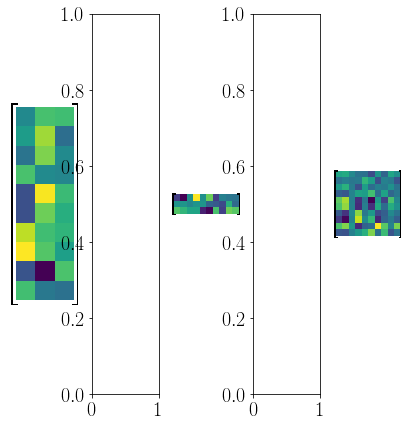

In [12]:
fig, ax = plt.subplots(1, 5,figsize=plot.big_figsize)
U = np.random.randn(10, 3)
VT = np.random.randn(3, 10)
plot.matrix(U, ax=ax[0], type='image')
plot.matrix(VT, ax=ax[2], type='image')
plot.matrix(np.dot(U,VT), ax=ax[4], type='image')


### Low Rank Approximation

<img src="../../slides/diagrams/wisuvt.svg">

In [ ]:
plot.deep_nn_bottleneck(diagrams='../../slides/diagrams/deepgp')

### Deep Neural Network

<img src="../../slides/diagrams/deepgp/deep-nn-bottleneck1.svg">

### Deep Neural Network

<img src="../../slides/diagrams/deepgp/deep-nn-bottleneck2.svg">

<object type="image/svg+xml" data="../diagrams/deep-nn1.svg">

### Mathematically 

$$
\begin{align}
    \latentVector_{1} &= \eigenvectwoMatrix^\top_1 \inputVector\\
    \hiddenVector_{1} &= \basisFunction\left(\eigenvectorMatrix_1 \latentVector_{1}\right)\\
    \latentVector_{2} &= \eigenvectwoMatrix^\top_2 \hiddenVector_{1}\\
    \hiddenVector_{2} &= \basisFunction\left(\eigenvectorMatrix_2 \latentVector_{2}\right)\\
    \latentVector_{3} &= \eigenvectwoMatrix^\top_3 \hiddenVector_{2}\\
    \hiddenVector_{3} &= \basisFunction\left(\eigenvectorMatrix_3 \latentVector_{3}\right)\\
    \dataVector &= \mappingVector_4^\top\hiddenVector_{3}
\end{align}
$$

### A Cascade of Neural Networks

$$\begin{align}
    \latentVector_{1} &= \eigenvectwoMatrix^\top_1 \inputVector\\
    \latentVector_{2} &= \eigenvectwoMatrix^\top_2 \basisFunction\left(\eigenvectorMatrix_1 \latentVector_{1}\right)\\
    \latentVector_{3} &= \eigenvectwoMatrix^\top_3 \basisFunction\left(\eigenvectorMatrix_2 \latentVector_{2}\right)\\
    \dataVector &= \mappingVector_4 ^\top \latentVector_{3}
\end{align}
$$

### Cascade of Gaussian Processes

* Replace each neural network with a Gaussian process
$$
\begin{align}
    \latentVector_{1} &= \mappingFunctionVector_1\left(\inputVector\right)\\
    \latentVector_{2} &= \mappingFunctionVector_2\left(\latentVector_{1}\right)\\
    \latentVector_{3} &= \mappingFunctionVector_3\left(\latentVector_{2}\right)\\
    \dataVector &= \mappingFunctionVector_4\left(\latentVector_{3}\right)
\end{align}
$$

* Equivalent to prior over parameters, take width of each layer to infinity.

### Mathematically 

-   Composite *multivariate* function
    $$\mathbf{g}(\inputVector)=\mappingFunctionVector_5(\mappingFunctionVector_4(\mappingFunctionVector_3(\mappingFunctionVector_2(\mappingFunctionVector_1(\inputVector)))))$$

In [ ]:
rc("font", **{'family':'sans-serif','sans-serif':['Helvetica'],'size':30})
rc("text", usetex=True)
pgm = plot.horizontal_chain(depth=5)
pgm.render().figure.savefig("../../slides/diagrams/deepgp/deep-markov.svg", transparent=True)

### Equivalent to Markov Chain 

-   Composite *multivariate* function

$$p(\dataVector|\inputVector)= p(\dataVector|\mappingFunctionVector_5)p(\mappingFunctionVector_5|\mappingFunctionVector_4)p(\mappingFunctionVector_4|\mappingFunctionVector_3)p(\mappingFunctionVector_3|\mappingFunctionVector_2)p(\mappingFunctionVector_2|\mappingFunctionVector_1)p(\mappingFunctionVector_1|\inputVector)$$

<img src="../../slides/diagrams/deepgp/deep-markov.svg">

In [ ]:
from matplotlib import rc
rc("font", **{'family':'sans-serif','sans-serif':['Helvetica'], 'size':15})
rc("text", usetex=True)
pgm = plot.vertical_chain(depth=5)
pgm.render().figure.savefig("../../slides/diagrams/deepgp/deep-markov-vertical.svg", transparent=True)

### 

<img src="../../slides/diagrams/deepgp/deep-markov-vertical.svg">

### Why Deep? 

-   Gaussian processes give priors over functions.

-   Elegant properties:

    -   e.g. *Derivatives* of process are also Gaussian distributed (if
        they exist).

-   For particular covariance functions they are ‘universal
    approximators’, i.e. all functions can have support under the prior.

-   Gaussian derivatives might ring alarm bells.

-   E.g. a priori they don’t believe in function ‘jumps’.

### Process Composition 


-   From a process perspective: *process composition*.

-   A (new?) way of constructing more complex *processes* based on
    simpler components.

### 

<img src="../../slides/diagrams/deepgp/deep-markov-vertical.svg">

In [ ]:
pgm = plot.vertical_chain(depth=5, shape=[2, 7])
pgm.add_node(daft.Node('y_2', r'$\mathbf{y}_2$', 1.5, 3.5, observed=True))
pgm.add_edge('f_2', 'y_2')
pgm.render().figure.savefig("../../slides/diagrams/deepgp/deep-markov-vertical-side.svg", transparent=True)

### 

<img src="../../slides/diagrams/deep-markov-vertical-side.svg">

In [ ]:
plot.non_linear_difficulty_plot_3(diagrams='../../slides/diagrams/dimred/')

### Difficulty for Probabilistic Approaches 

-   Propagate a probability distribution through a non-linear mapping.

-   Normalisation of distribution becomes intractable.

<img src="../../slides/diagrams/dimred/nonlinear-mapping-3d-plot.svg"  align="center">

In [ ]:
plot.non_linear_difficulty_plot_2(diagrams='../../slides/diagrams/dimred/')

### Difficulty for Probabilistic Approaches 

-   Propagate a probability distribution through a non-linear mapping.

-   Normalisation of distribution becomes intractable.

<img src="../../slides/diagrams/dimred/nonlinear-mapping-2d-plot.svg"  align="center">

In [ ]:
plot.non_linear_difficulty_plot_1(diagrams='../../slides/diagrams/dimred')

### Difficulty for Probabilistic Approaches

-   Propagate a probability distribution through a non-linear mapping.

-   Normalisation of distribution becomes intractable.

<img src="../../slides/diagrams/dimred/gaussian-through-nonlinear.svg"  align="center">

### Deep Gaussian Processes

-   Deep architectures allow abstraction of features
    [@Bengio:deep09; @Hinton:fast06; @Salakhutdinov:quantitative08]

-   We use variational approach to stack GP models.


In [ ]:
plot.stack_gp_sample(kernel=GPy.kern.Linear,
                     diagrams="../../slides/diagrams/deepgp")

## Stacked PCA

In [ ]:
pods.notebook.display_plots('stack-gp-sample-Linear-{sample:0>1}.svg', 
                            directory='../../slides/diagrams/deepgp', sample=(0,4))

In [ ]:
plot.stack_gp_sample(kernel=GPy.kern.RBF,
                     diagrams="../../slides/diagrams/deepgp")

### Stacked GP

In [ ]:
pods.notebook.display_plots('stack-gp-sample-RBF-{sample:0>1}.svg', 
                            directory='../../slides/diagrams/deepgp', sample=(0,4))

### Analysis of Deep GPs 

- *Avoiding pathologies in very deep networks*
    @Duvenaud:pathologies14 show that the derivative
    distribution of the process becomes more *heavy tailed* as number of
    layers increase.

- *How Deep Are Deep Gaussian Processes?*
    @Dunlop:deep2017 perform a theoretical analysis possible through conditional Gaussian Markov property.

###


In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('XhIvygQYFFQ')

### Olympic Marathon Data

See [this notebook](./dgp_supervised.ipynb) for experiments.

### Olympic Marathon Data

<img src="../../slides/diagrams/datasets/olympic-marathon.svg"> 

### Olympic Marathon Data GP 

<img src="../../slides/diagrams/gp/olympic-marathon-gp.svg"> 

### Olympic Marathon Data Deep GP 

<img src="../../slides/diagrams/deepgp/olympic-marathon-deep-gp.svg"> 

### Olympic Marathon Data Latent 1 

<img src="../../slides/diagrams/deepgp/olympic-marathon-deep-gp-layer-1.svg"> 

### Olympic Marathon Data Latent 2 

<img src="../../slides/diagrams/deepgp/olympic-marathon-deep-gp-layer-2.svg"> 

### Step Function Data 

<img src="../../slides/diagrams/datasets/step-function.svg"> 

### Step Function Data GP 

<img src="../../slides/diagrams/gp/step-function-gp.svg"> 

### Step Function Data Deep GP 

<img src="../../slides/diagrams/deepgp/step-function-deep-gp.svg"> 

### Step Function Data Deep GP 

<img src="../../slides/diagrams/deepgp/step-function-deep-gp-sample.svg"> 

### Step Function Data Latent 1 

<img src="../../slides/diagrams/deepgp/step-function-deep-gp-layer-1.svg"> 

### Step Function Data Latent 2 

<img src="../../slides/diagrams/deepgp/step-function-deep-gp-layer-2.svg"> 

### Motorcycle Helmet Data 

<img src="../../slides/diagrams/datasets/motorcycle-helmet.svg"> 

### Motorcycle Helmet Data GP 

<img src="../../slides/diagrams/gp/motorcycle-helmet-gp.svg"> 

### Motorcycle Helmet Data Deep GP 

<img src="../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp.svg"> 

### Motorcycle Helmet Data Deep GP 

<img src="../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp-sample.svg"> 

### Motorcycle Helmet Data Latent 1 

<img src="../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp-layer-1.svg"> 

### Motorcycle Helmet Data Latent 2 

<img src="../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp-layer-2.svg"> 

### Robot WiFi Data

<img src="../../slides/diagrams/datasets/robot-wireless-dim-1.svg"> 

### Robot WiFi Data GP

<img src="../../slides/diagrams/gp/robot-wireless-gp-dim-1.svg"> 

### Robot WiFi Data GP

<img src="../../slides/diagrams/deepgp/robot-wireless-deep-gp-dim-1.svg"> 

### Robot WiFi Data Latent Space

<img src="../../slides/diagrams/deepgp/robot-wireless-ground-truth.svg"> 

### Robot WiFi Data Latent Space

<img src="../../slides/diagrams/deepgp/robot-wireless-latent-space.svg"> 

### Motion Capture

-   ‘High five’ data.

-   Model learns structure between two interacting subjects.

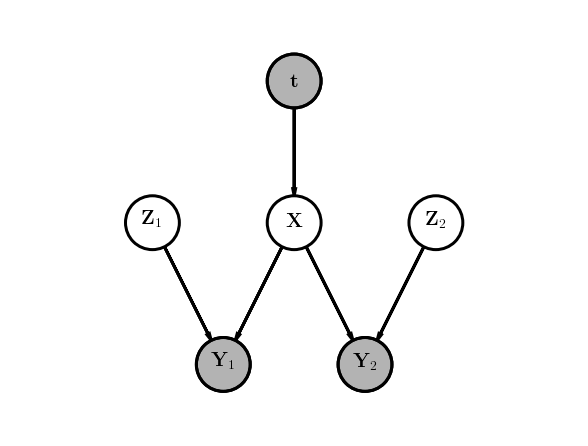

In [2]:
rc("font", **{'family':'sans-serif','sans-serif':['Helvetica'], 'size':20})
rc("text", usetex=True)
pgm = plot.shared_gplvm()
pgm.render().figure.savefig("../../slides/diagrams/deepgp/shared.svg", transparent=True)

### Shared LVM

<img src="../../slides/diagrams/deepgp/shared.svg">

###

<img src="../slides/diagrams/deep-gp-high-five2.png"  width="100%" class="negate" align="cener" style="background:none; border:none; box-shadow:none;">

### Digits Data Set

-   Are deep hierarchies justified for small data sets?

-   We can lower bound the evidence for different depths.

-   For 150 6s, 0s and 1s from MNIST we found at least 5 layers are
    required.

###

<img src="../../slides/diagrams/deep-gp-usps-digits.png"  width="100%" class="negate" align="cener" style="background:none; border:none; box-shadow:none;">

###

<img src="../../slides/diagrams/deepgp/digit-samples-deep-gp.svg">

###

<img src="../../slides/diagrams/deepgp/usps-digits-latent.svg">

###

<img src="../../slides/diagrams/deepgp/usps-digits-hidden-1-0.svg">

###

<img src="../../slides/diagrams/deepgp/usps-digits-hidden-2-0.svg">

###

<img src="../../slides/diagrams/deepgp/usps-digits-hidden-3-0.svg">

###

<img src="../../slides/diagrams/deepgp/usps-digits-hidden-4-0.svg">

In [4]:
pods.notebook.display_plots('usps-digits-hidden-{sample:0>1}-0.svg', 
                            directory='../../slides/diagrams', sample=(1,4))

A Jupyter Widget